In [1]:
from configs import Config

config_mbf = Config(model_name='mbf_large', 
                    target_ckpt_path='weights/backbone/mbf_large.pt', 
                    shadow_ckpt_path='weights/shadow/mbf_large.ckpt')

config_dp_mbf = Config(model_name='dp_mbf_large', 
                    target_ckpt_path='weights/backbone/dp_mbf_large.pt', 
                    shadow_ckpt_path='weights/shadow/dp_mbf_large.ckpt')

In [2]:
from dataset import get_dataModule
mbf_dataModule = get_dataModule(config_mbf)
dp_mbf_dataModule = get_dataModule(config_dp_mbf)

2024-02-28 15:05:28.240312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 15:05:28.240343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 15:05:28.240998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 15:05:28.244796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 15:05:29.714907: W tensorflow/compiler/tf2

In [3]:
from model import get_backbone, get_shadow
backbone = get_backbone(config_mbf)
backbone_dp = get_backbone(config_dp_mbf)
shadow = get_shadow(config_mbf, backbone, None)
shadow_dp = get_shadow(config_dp_mbf, backbone_dp, None)

Loaded the checkpoint from weights/backbone/mbf_large.pt
Loaded the checkpoint from weights/backbone/dp_mbf_large.pt
Loaded the checkpoint from weights/shadow/mbf_large.ckpt
Loaded the checkpoint from weights/shadow/dp_mbf_large.ckpt


In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
backbone.eval()
backbone_dp.eval()
shadow.eval()
shadow_dp.eval()
print(f"Move all model to {device}")

Move all model to cuda


In [5]:
# turn the image to tensor
test_loader = mbf_dataModule.test_dataloader()
dp_test_loader = dp_mbf_dataModule.test_dataloader()

In [6]:
from tqdm import tqdm
imgs_ori = []
imgs_rec = []
imgs_dprec = []
dpimgs_ori = []
dpimgs_rec = []
dpimgs_dprec = []

In [7]:
shadow.to(device)
shadow_dp.to(device)

for img, feat in tqdm(test_loader):
    feat = feat.to(device)
    with torch.no_grad():
        imgs_ori.append(img)
        imgs_rec.append(shadow(feat))
        imgs_dprec.append(shadow_dp(feat))

for img, feat in tqdm(dp_test_loader):
    feat = feat.to(device)
    with torch.no_grad():
        dpimgs_ori.append(img)
        dpimgs_rec.append(shadow(feat))
        dpimgs_dprec.append(shadow_dp(feat))


100%|██████████| 17/17 [00:00<00:00, 19.82it/s]


In [8]:
imgs_ori_tensor = torch.concat(imgs_ori, dim=0)
imgs_rec_tensor = torch.concat(imgs_rec, dim=0)
imgs_dprec_tensor = torch.concat(imgs_dprec, dim=0)
dpimgs_ori_tensor = torch.concat(dpimgs_ori, dim=0)
dpimgs_rec_tensor = torch.concat(dpimgs_rec, dim=0)
dpimgs_dprec_tensor = torch.concat(dpimgs_dprec, dim=0)

In [29]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from typing import List


def tensor2img(tensor: torch.Tensor) -> cv2.Mat:
    tensor = tensor.permute(1, 2, 0) * 255
    ndarray = tensor.cpu().detach().numpy().astype(np.uint8)
    img = cv2.cvtColor(ndarray, cv2.COLOR_BGR2RGB)
    return img


def draw_rows(img_rows: List[torch.Tensor], row_titles: List[str], n_pair=20, save_path=""):

    n_rows = len(img_rows)
    fig, axes = plt.subplots(n_rows, n_pair, figsize=(n_pair*0.5, n_rows*0.5))
    fig.subplots_adjust(wspace=0, hspace=0, left=0.11)

    for row, (img_row, title) in enumerate(zip(img_rows, row_titles)):

        fig.text(0.05, (n_rows-row) / (n_rows+1), title, ha='left', va='center')

        for col, img in enumerate(img_row[:n_pair]):
            img = tensor2img(img)
            ax = axes[row][col]
            ax.imshow(img)
            ax.set_axis_off()

    fig.savefig(save_path)


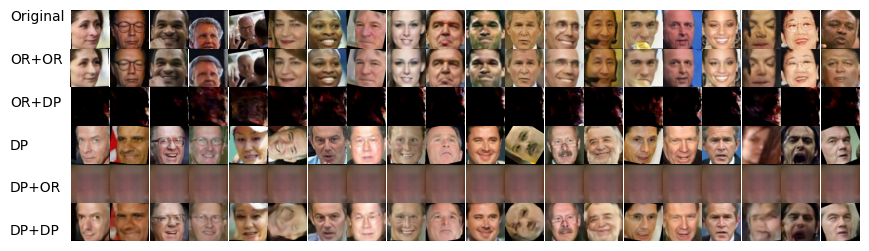

In [31]:
draw_rows(
    img_rows=[imgs_ori_tensor, imgs_rec_tensor, imgs_dprec_tensor, dpimgs_ori_tensor, dpimgs_rec_tensor, dpimgs_dprec_tensor],
    row_titles=['Original', 'OR+OR', 'OR+DP', 'DP', 'DP+OR', 'DP+DP'],
    save_path="./output/test.png"
)